# homework

In [680]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [681]:
data = pd.read_csv('data/ab_data_tourist.csv')
data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


* `user_id` — идентификатор пользователя, зашедшего на сайт;
* `data` — дата посещения сайта;
* `group` — группа теста (контрольная — А или тестовая — B);
* `purchase` — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
* `price` — цена купленного тура (если покупка не состоялась, цена равна 0).

### Задание 1. Проанализируйте структуру данных и проведите их предобработку

* исследуйте структуру данных;
* преобразуйте столбцы к необходимым типам данных.
* Убедитесь в одинаковой длительности проведения A/B-тестирования в каждой из групп. Если длительность разная, унифицируйте данные, удалив лишние данные для соответствующей группы.
* Проверьте данные на наличие пропусков и избавьтесь от них, если нужно.
* Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе группы. Если да, исключите пользователей, оказавшихся в обеих группах.

In [682]:
# посмотрим типы данных/наличие пропусков и проведем нужное преобразование
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [683]:
# преобразуем в формат дататайм
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

In [684]:
user_a = set(data[data['group']=='A']['user_id'])
user_b = set(data[data['group']=='B']['user_id'])

user_intersection = user_b.intersection(user_a)
print(f'Количество пользователей, которые попали как в группу А, так и в группу В: {len(list(user_intersection))}')
data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Количество пользователей, которые попали как в группу А, так и в группу В: 1895


In [685]:
count_a = data[data['group']=='A']['user_id'].count()
count_b = data[data['group']=='B']['user_id'].count()
count_sum_a = data[data['group']=='A']['purchase'].sum()
count_sum_b = data[data['group']=='B']['purchase'].sum()
total_sum_a = data[data['group']=='A']['price'].sum()/1000000
total_sum_b = data[data['group']=='B']['price'].sum()/1000000
print(f'Количество посещение в группе А {count_a}')
print(f'Количество посещение в группе B {count_b}')
print(f'Количество покупок в группе А {count_sum_a}')
print(f'Количество покупок в группе B {count_sum_b}')
print(f'Сумма покупок в группе А {total_sum_a}')
print(f'Сумма покупок в группе B {total_sum_b}')

Количество посещение в группе А 145307
Количество посещение в группе B 145381
Количество покупок в группе А 17487
Количество покупок в группе B 17290
Сумма покупок в группе А 1417.78
Сумма покупок в группе B 1533.01


Проверяем диапазон дат для проведения теста

In [686]:
# Определяем минимальное и максимальное значения даты для каждой группы
min_date_a = data[data['group'] == 'A']['date'].min()
max_date_a = data[data['group'] == 'A']['date'].max()
min_date_b = data[data['group'] == 'B']['date'].min()
max_date_b = data[data['group'] == 'B']['date'].max()

# Определяем общий диапазон дат
min_date = max(min_date_a, min_date_b)
max_date = min(max_date_a, max_date_b)

# Фильтруем данные, оставляя только строки в общем диапазоне дат
data = data[(data['date'] >= min_date) & (data['date'] <= max_date)]

In [687]:
data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


Таким образом мы выполнили первое задание, гда проанализирровали структуру данных и провели их предобработку, а именно:

* проверили данные на нилчие пропусков
* проверили данные на наличии дубликатов и участия одного пользователя в двух тестах
* задали нужный диапазон для для честного тестирования

`Отклонение количества наблюдений в группе А от группы В составляет 0,05%. Таким образом, можно сделать вывод, что выборка сбалансирована.`

### Задание 2. Сделайте первичный анализ результатов A/B-тестирования

Рассчитайте вспомогательные показатели для контрольной и тестовой групп:
* количество посещений сайта;
* суммарное количество совершённых покупок;
* сумма всех покупок.

Сделайте промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной страницы? Можно ли говорить о сбалансированности выборок?

В каждой из групп рассчитайте ключевые показатели:
* конверсия;
* средний чек.

Сделайте первичные выводы о результатах A/B-тестирования на основе показателей конверсии и среднего чека в каждой из групп. По какому(-им) показателю(-ям), на первый взгляд, вариант А эффективнее варианта B и наоборот?

Сравните варианты A/B по покупательской способности каждого из туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. Визуализируйте полученную сводную таблицу.

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем покупательская способность участников группы B, и наоборот?

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

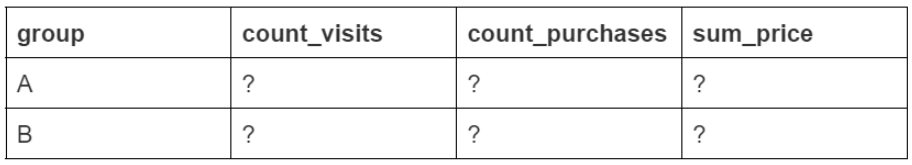

Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:

* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на count_visits, count_purchases и sum_price.

In [688]:
group_data = data.groupby('group').agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index()
rename_group_data = group_data.rename(columns={
    'user_id':'count_visits',
    'purchase':'count_purchases',
    'price':'sum_price'
})
rename_group_data 

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Отклонение количества наблюдений в группе А от группы В составляет 0,05%. Таким образом, можно сделать вывод, что выборка сбалансирована.

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [689]:
rename_group_data['conversion'] = round(rename_group_data['count_purchases']/rename_group_data['count_visits']*100,2)
rename_group_data['mean_check'] = round(rename_group_data['sum_price']/rename_group_data['count_purchases'],0)
rename_group_data.head()

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

На данном этапе вариант А эффективнее по показателю конверсии, но у варианта В выше средний чек.

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура.

In [691]:
group_updated_data = data.groupby(['group','price'])['purchase'].sum().unstack()
group_updated_data


price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Зависимость количества продаж от группы и цены тура')

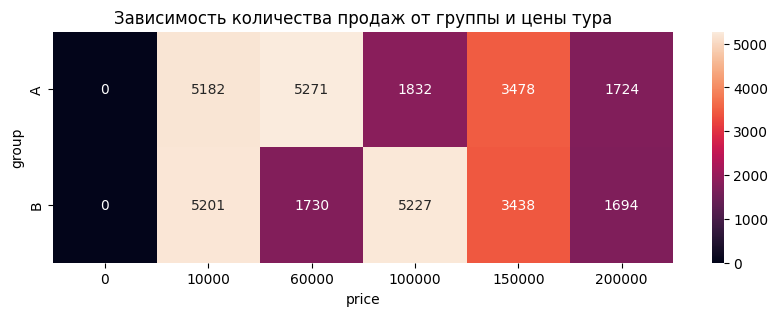

In [692]:
plt.figure(figsize = (10,3))
sp = sns.heatmap(group_updated_data, annot=True, fmt=".0f")
sp.set_title("Зависимость количества продаж от группы и цены тура")

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

По тепловой карте можно сделать вывод, что клиенты в группе А чаще покупают туры стоимостью 10 и 60 тыс.руб, клиенты в группе В чаще покупают туры стоимостью 10000 и 100000. В остальных категориях значения сопоставимы. Таким образом, при одинаковых количествах проданых туров, выручка в группе В будет выше.

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок.

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)

Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [694]:
group_by_date_data = data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index()

rename_group_by_date_data = group_by_date_data.rename(columns={
    'user_id':'count_visits',
    'purchase':'count_purchases',
    'price':'sum_price'
})

rename_group_by_date_data['conversion'] = round(rename_group_by_date_data['count_purchases']/rename_group_by_date_data['count_visits']*100,2)
rename_group_by_date_data['mean_check'] = round(rename_group_by_date_data['sum_price']/rename_group_by_date_data['count_purchases'])
rename_group_by_date_data.head()

rename_group_by_date_data[rename_group_by_date_data['date'] == '2021-01-03']

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0


Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам.

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей.
* Какая кумулятивная конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой кумулятивный средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [695]:
#Добавим столбцы с кумулятивными значениями: количество посещений страницы, количество покупок, сумма покупок
rename_group_by_date_data['cum_users_count'] = rename_group_by_date_data.groupby('group')['count_visits'].cumsum()
rename_group_by_date_data['cum_count_purchases'] = rename_group_by_date_data.groupby('group')['count_purchases'].cumsum()
rename_group_by_date_data['cum_sum_price'] = rename_group_by_date_data.groupby('group')['sum_price'].cumsum()

#Вычислим кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей
rename_group_by_date_data['cum_conversion'] = round(rename_group_by_date_data['cum_count_purchases']/rename_group_by_date_data['cum_users_count']*100, 2)
rename_group_by_date_data['cum_mean_check'] = round(rename_group_by_date_data['cum_sum_price']/rename_group_by_date_data['cum_count_purchases'])

print('Кумулятивная конверсия на 20 января:')
display(rename_group_by_date_data[rename_group_by_date_data['date'] == '2021-01-20'][['group','cum_conversion']])
print('Средний чек на 12 января:')
display(rename_group_by_date_data[rename_group_by_date_data['date'] == '2021-01-12'][['group','cum_mean_check']])

Кумулятивная конверсия на 20 января:


,group,cum_conversion
36,A,11.98
37,B,11.90


Средний чек на 12 января:


,group,cum_mean_check
20,A,81492.0
21,B,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

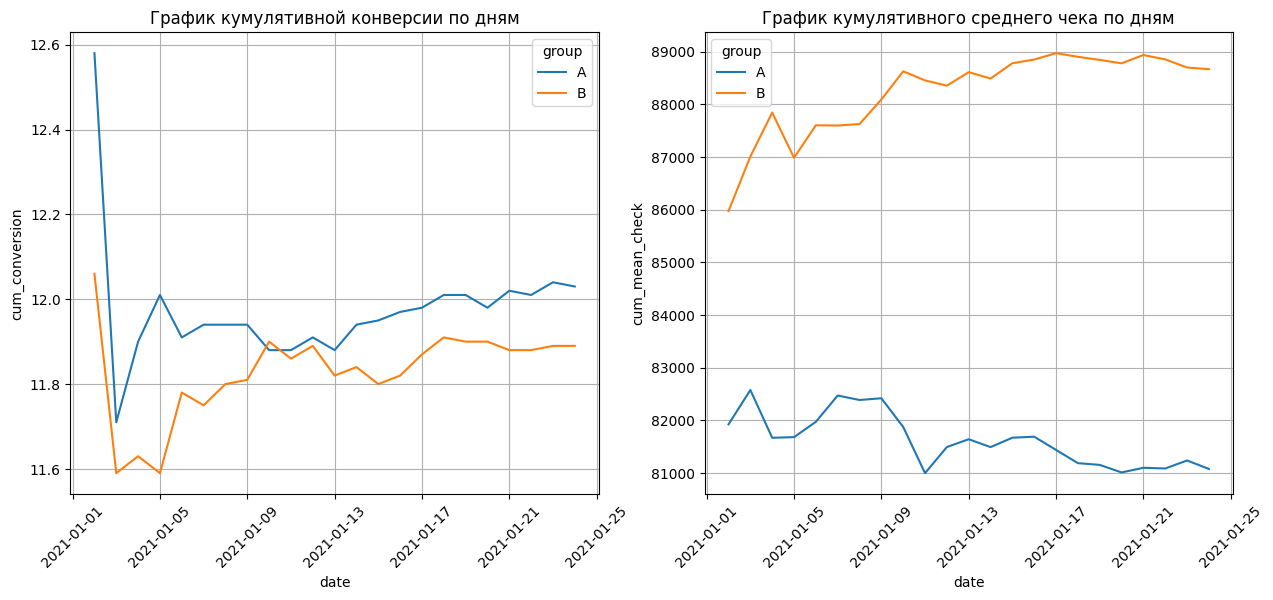

In [696]:
#А теперь построим графики кумулятивной конверсии по дням в каждой группе:
# создаём фигуру размером 8x4
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=rename_group_by_date_data, hue='group', ax=ax[0])
sns.lineplot(x='date', y='cum_mean_check', data=rename_group_by_date_data, hue='group', ax=ax[1])
# задаём подпись к графику
ax[0].set_title('График кумулятивной конверсии по дням')
ax[1].set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax[0].xaxis.set_tick_params(rotation=45)
ax[1].xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax[0].grid(True)
ax[1].grid(True);

Кумулятивная конверсия в группе А выше чем в группе В за весь период наблюдения кроме 10.01.2021г. Пиковое значение в обоих группах приходится на 2 января (начало наблюдений), далее спад 3 января. Значения стабилизировались после 15.01.2021г. Средний чек в группе В выше, чем в группе А за весь период наблюдений, кроме того значение среднего чека в группе B растет в течение времени, а в группе А снижается.

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны;
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $a$
=0.05.

In [698]:
converted_piv = data.groupby('group')['purchase'].agg(['sum','count'])
display(converted_piv)
#нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

,sum,count
group,,
A,17487,145307
B,17290,145381


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

При уровне значимости 0,05 статистическая разница между конверсиями в группах А и В отсутствует. Решение о выборе между вариантами не может быть принято на основании показателя конверсии.

Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними.

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [700]:
#Построим доверительные интервалы для конверсии по группам
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

#создадим дата сеты для групп А и В
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']

#Теперь применим нашу функцию к данным группы А и группы B:
conf_interval_a = proportions_conf_interval(
n=a_data['purchase'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['purchase'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

#Построим доверительные интервалы для разницы между конверсиями
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

#Вызовем функцию и построим интересующий нас доверительный интервал:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

С вероятностью 95% среднее значение конверсии в группе А лежит в диапазоне от 11.87 до 12.2, в группе В в диапазоне от 11.73 до 12.06. Оба доверительных интервала имеют общие значения в диапазоне от 11.87 до 12.06. Доверительный интервал разницы конверсий лежит в диапазоне от -0.38 до 0.09. Это значит, что что варианты А и B равнозначны по метрике конверсии.

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования.
* Какой тест вы примените для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $a$=0.05?

In [701]:
H0 = 'Данные распределены нормально'
Ha = 'Распределение отлично от нормального'

alpha = 0.05

a_data_2 = rename_group_by_date_data[rename_group_by_date_data['group'] == 'A']
b_data_2 = rename_group_by_date_data[rename_group_by_date_data['group'] == 'B']

shapiro_a = shapiro(a_data_2['mean_check'])
shapiro_b = shapiro(b_data_2['mean_check'])

print('p-value группы А', round(shapiro_a.pvalue, 2))
print('p-value группы B', round(shapiro_b.pvalue, 2))

# Интерпретация 

if shapiro_a.pvalue < alpha or shapiro_b.pvalue < alpha:
	print(Ha)
else:
	print(H0)

p-value группы А 0.25
p-value группы B 0.09
Данные распределены нормально


Настало время сравнить варианты дизайна страницы по метрике среднего чека.

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны;
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $a$=0.05.

In [702]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=a_data_2['mean_check'],
    b=b_data_2['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

С вероятностью 95% средний чек в группе В окажется выше, чем средний чек в группе А. Вариант В более предпочтителен.

In [704]:
def ttest_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 # число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return round(lower_bound), round(upper_bound)

a_data_2 = rename_group_by_date_data[rename_group_by_date_data['group'] == 'A']
b_data_2 = rename_group_by_date_data[rename_group_by_date_data['group'] == 'B']

#Теперь применим нашу функцию к данным группы А и группы B:
ttest_interval_a = ttest_interval(
n = a_data_2['count_visits'].count(), # размер выборки
x_mean = a_data_2['mean_check'].mean(), # выборочное среднее
x_std = a_data_2['mean_check'].std() # выборочное стандартное отклонение
)
ttest_interval_b = ttest_interval(
n = b_data_2['count_visits'].count(), # размер выборки
x_mean = b_data_2['mean_check'].mean(), # выборочное среднее
x_std = b_data_2['mean_check'].std() # выборочное стандартное отклонение
)
print('Доверительный интервал для конверсии группы А: {}'.format(ttest_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(ttest_interval_b))


Доверительный интервал для конверсии группы А: (79630, 82308)
Доверительный интервал для конверсии группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

С вероятностью 95% среднее значение конверсии в группе А лежит в диапазоне от 79 630 до 82 308, в группе В в диапазоне от 87 626 до 89 526. Доверительные интервалы не имеют общих значений. Все значения доверительного интервала варианта В выше значений доверительного интервала варианта В. Таким образом вариант В более предпочтителен.

### Общий вывод по результатам A/B-теста
По резултату А/В теста предпочтение следует отдать варианту В. Поскольку средний чек в группе В выше, чем в группе А. А результаты исследования разницы конверсий не показали статистически значимых отклонений.